<a href="https://colab.research.google.com/github/CoderAPS/neural_nets/blob/main/image_segmentation3(20230512_v6_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set up an esemble image segmentation model using oxford_iiit_pet dataset. nn

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
!ls /gdrive/MyDrive/saved_models


oxford_pet_img-segment	training_1


In [3]:
# Check RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output


import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm.notebook import tqdm_notebook

%matplotlib inline 

In [5]:

pip install segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.1 MB/s eta 0:00:00


In [6]:
# Import segmentation models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from segmentation_models.utils import set_trainable

Segmentation Models: using `tf.keras` framework.


In [7]:
# Check versions
print (f'Tensorflow: {tf.__version__}')
print(f'Kears: {keras.__version__}')
p = !python --version
print(f'Python: {p[0]}')

Tensorflow: 2.12.0
Kears: 2.12.0
Python: Python 3.10.11


In [ ]:
# split dataset into 85% train, 10% validation and 5% test
# during training create a validation set from training set
dataset,info = tfds.load('oxford_iiit_pet:3.*.*', 
                                split=['train+test[:78%]',
                                       'test[78%:98%]',
                                       'test[98%:]'],
                                with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [9]:
# Check number of image in the three subsets
print(f'Number of images/masks in train set: {len(dataset[0])}')
print(f'Number of images/masks in validation set: {len(dataset[1])}')
print(f'Number of images/masks in test set: {len(dataset[2])}')

Number of images/masks in train set: 6542
Number of images/masks in validation set: 734
Number of images/masks in test set: 73


In [10]:
# Declare some global varaiables
img_height = 128
img_width = 128
num_classes = 3
divide = 255
# Randomly assigned image number from validation set to display original image 
# instead of pre-trained model preprocessed validation image
img_num = None
# The randomly selected image from validation with img_num which is preprocessed 
# for pre-trained model
sample_image = None

current_model = None


In [11]:
# Function to resize images and segmentation masks
# subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2} from {1,2,3}
def resize_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (img_height, img_width))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (img_height, img_width),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_mask -= 1

  return input_image, input_mask

In [12]:
# Create train, val and test variables and assign the respective dataset
train_dataset = dataset[0].map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = dataset[1].map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset[2].map(resize_image,num_parallel_calls=tf.data.AUTOTUNE)

In [13]:

# Check for faulty masks - the pixels classification for these is not split into three
train_counter = 0
for img,mask in tqdm_notebook(train_dataset.take(len(train_dataset)),
                              total=len(train_dataset)):
  if len(np.unique(mask.numpy())) != 3:
    train_counter += 1 

val_counter = 0
for img,mask in tqdm_notebook(val_dataset.take(len(val_dataset)),
                              total=len(val_dataset)):
  if len(np.unique(mask.numpy())) != 3:
    val_counter += 1 

test_counter = 0
for img,mask in tqdm_notebook(test_dataset.take(len(test_dataset)),total=len(test_dataset)):
  if len(np.unique(mask.numpy())) != 3:
    test_counter += 1 

print(f'Number of train faulty masks: {train_counter}.')
print(f'Number of val faulty masks: {val_counter}.')
print(f'Number of test faulty masks: {test_counter}.')

  0%|          | 0/6542 [00:00<?, ?it/s]

  0%|          | 0/734 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Number of train faulty masks: 12.
Number of val faulty masks: 2.
Number of test faulty masks: 0.


In [14]:
# Creat train numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list
# Exclude images and masks where the mask does not have all 3 values

# Allocate memory for numpy arrays
# train images
num_train = len(train_dataset) - train_counter
X_train = np.zeros(shape=(num_train,128,128,3)) 
# train masks
Y_train = np.zeros(shape=(num_train,128,128,1))

idx = 0
counter = 0
for img,mask in tqdm_notebook(train_dataset.take(len(train_dataset)),
                              total=len(train_dataset)):
    if len(np.unique(mask.numpy())) == 3: 
      X_train[idx] = img
      Y_train[idx] = mask
      idx += 1
    else:
      counter += 1

print (f'Completed transfer of: {len(X_train)} images and masks.')
print(f'Number of faulty masks: {counter}.')

  0%|          | 0/6542 [00:00<?, ?it/s]

Completed transfer of: 6530 images and masks.
Number of faulty masks: 12.


In [15]:
# Creat val numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list
# Exclude images and masks where the mask does not have all 3 values

# Allocate memory for numpy arrays
# val images
num_val = len(val_dataset) - val_counter
X_val = np.zeros(shape=(num_val,128,128,3)) 
# val masks
Y_val = np.zeros(shape=(num_val,128,128,1))

idx = 0
counter = 0
for img,mask in tqdm_notebook(val_dataset.take(len(val_dataset)),
                              total=len(val_dataset)):
    if len(np.unique(mask.numpy())) == 3: 
      X_val[idx] = img
      Y_val[idx] = mask
      idx += 1
    else:
      counter += 1

print (f'Completed transfer of: {len(X_val)} images and masks.')
print(f'Number of faulty masks: {counter}.')

  0%|          | 0/734 [00:00<?, ?it/s]

Completed transfer of: 732 images and masks.
Number of faulty masks: 2.


In [16]:
# Create test numpy arrays for X and y
# Transfer images, masks into numpy arrays
# By converting PrefetchDataset(dataset[0],dataset[1],dataset[2]) into numpy
# and then them to respective list
# Exclude images and masks where the mask does not have all 3 values

# Allocate memory for numpy arrays
# test images
num_test = len(test_dataset) - test_counter
X_test = np.zeros(shape=(num_test,128,128,3)) 
# test masks
Y_test = np.zeros(shape=(num_test,128,128,1))

idx = 0
counter = 0
for img,mask in tqdm_notebook(test_dataset.take(len(test_dataset)),
                              total=len(test_dataset)):
    if len(np.unique(mask.numpy())) == 3: 
      X_test[idx] = img
      Y_test[idx] = mask
      idx += 1
    else:
      counter += 1

print (f'Completed transfer of: {len(X_val)} images and masks.')
print(f'Number of faulty masks: {counter}.')

  0%|          | 0/73 [00:00<?, ?it/s]

Completed transfer of: 732 images and masks.
Number of faulty masks: 0.


In [17]:
# Display image, repective mask and model prediction 
def display(data_list):
  #pred = data_list[2]
  #print(f'def display(): pred: {pred.shape}')
  plt.figure(figsize=(12,8))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(data_list)):
    plt.subplot(1, len(data_list), i+1)
    plt.title(title[i])
    # if input is image divide by 255 and display  
    # else display input (for mask and predictions) as is
    plt.imshow(data_list[i]/divide) if i == 0 else plt.imshow(data_list[i])
       
    plt.axis('off')
  plt.show()

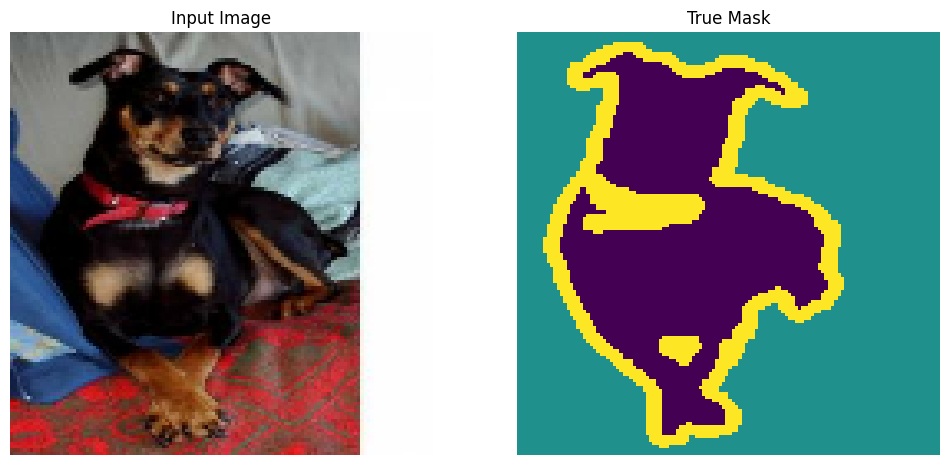

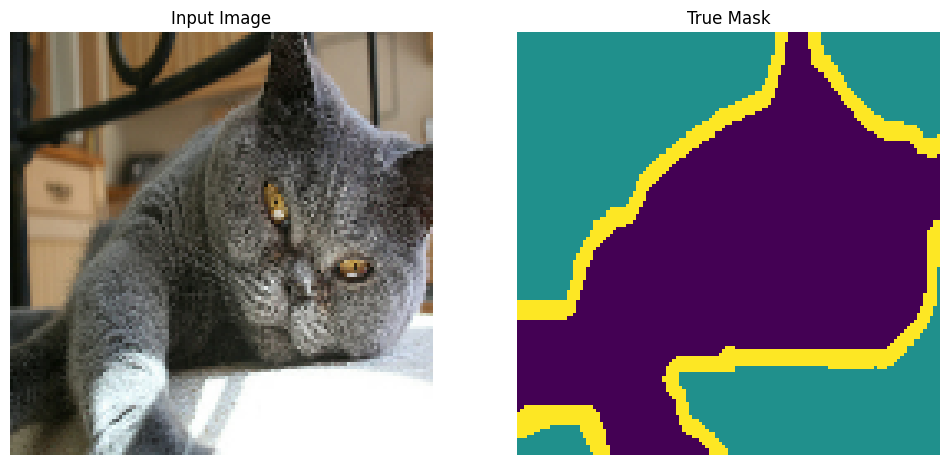

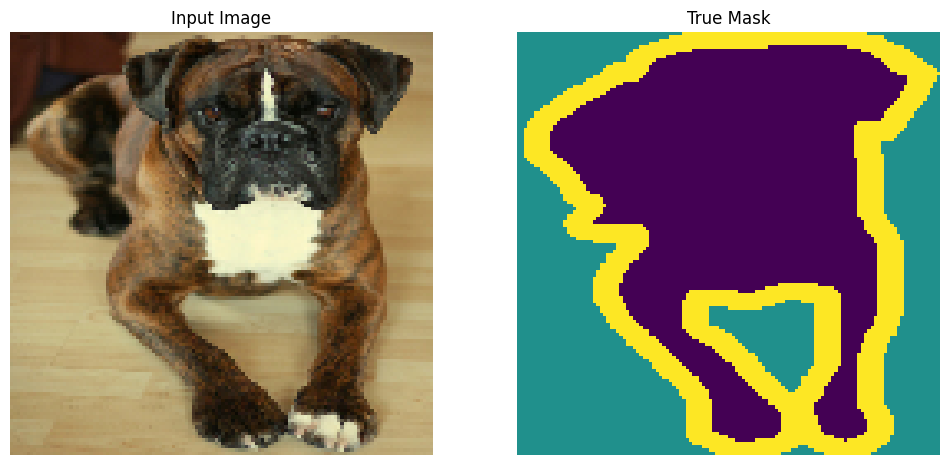

In [18]:
# Randomly select an image and its respective mask 3 times for display
for i in range(3):
  num = np.random.randint(len(X_train))
  display([X_train[num],Y_train[num]])

In [19]:
# Check shape and type
print(f'Shape of X_train: {X_train.shape}\tData type: {type(X_train)}')
print(f'Shape of Y_train: {Y_train.shape}\tData type: {type(Y_train)}')
print(f'Shape of X_val: {X_val.shape}\tData type: {type(X_val)}')
print(f'Shape of Y_val: {Y_val.shape}\tData type: {type(Y_val)}')
print(f'Shape of X_test: {X_test.shape}\tData type: {type(X_test)}')
print(f'Shape of Y_test: {Y_test.shape}\tData type: {type(Y_test)}')

Shape of X_train: (6530, 128, 128, 3)	Data type: <class 'numpy.ndarray'>
Shape of Y_train: (6530, 128, 128, 1)	Data type: <class 'numpy.ndarray'>
Shape of X_val: (732, 128, 128, 3)	Data type: <class 'numpy.ndarray'>
Shape of Y_val: (732, 128, 128, 1)	Data type: <class 'numpy.ndarray'>
Shape of X_test: (73, 128, 128, 3)	Data type: <class 'numpy.ndarray'>
Shape of Y_test: (73, 128, 128, 1)	Data type: <class 'numpy.ndarray'>


In [20]:
# Convert masks/labels to categorical (onehot encode)
Y_train_cat = to_categorical(Y_train.copy(),num_classes)
Y_val_cat = to_categorical(Y_val.copy(), num_classes)
Y_test_cat = to_categorical(Y_test.copy(),num_classes)

In [21]:
print(f'Y_train_cat.shape: {Y_train_cat.shape}')
print(f'Y_val_cat.shape: {Y_val_cat.shape}')
print(f'Y_test_cat.shape: {Y_test_cat.shape}')

Y_train_cat.shape: (6530, 128, 128, 3)
Y_val_cat.shape: (732, 128, 128, 3)
Y_test_cat.shape: (73, 128, 128, 3)


In [22]:
# Create prediction mask
def create_mask(pred_mask):
  # Returns the maximum probability classification for each pixel (0,1,or2)
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  # Expands axis at the end
  pred_mask = pred_mask[..., tf.newaxis]
  
  return pred_mask


In [ ]:
# https://stackoverflow.com/questions/64312153/tf-newaxis-operation-in-tensorflow
a = tf.constant([100])
print(a.shape) ## (1)
expanded_1 = tf.expand_dims(a,axis=1)
print(expanded_1.shape) ## (1,1)
expanded_2 = a[:, tf.newaxis]
print(expanded_2.shape) ## (1,1)


(1,)
(1, 1)
(1, 1)


In [23]:
# Display image, mask and prediction mask
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = current_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    pred = current_model.predict(sample_image[tf.newaxis,...])
    pred_mask = create_mask(pred)
    display([X_val[img_num], Y_val[img_num],pred_mask[0]])

In [24]:
# Display image, mask and prediction mask after each epoch
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch))

In [25]:
# Show train and val loss and meanIOU and learning rate
def show_history(model_history):
  print(f'{model_history.history.keys()}')

  var = list(model_history.history.keys())
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']

  mean_iou = model_history.history[var[1]]
  val_mean_iou = model_history.history[var[-2]]
  
  learning_rate = model_history.history[var[-1]]

  epochs_range = model_history.epoch

  plt.figure(figsize=(14, 6))
  plt.subplot(1, 3, 1)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')


  plt.subplot(1, 3, 2)
  plt.plot(epochs_range, mean_iou, label='Training MeanIoU')
  plt.plot(epochs_range, val_mean_iou, label='Validation MeanIoU')
  plt.legend(loc='lower right')
  plt.title('Training and Validation IoU')

  plt.subplot(1,3,3)
  plt.plot(epochs_range,learning_rate,label='Learning Rate')
  plt.legend(loc='upper right')
  plt.title('Learning Rate')
  plt.show()

  
  train_loss = model_history.history['loss'][-1]
  val_loss = model_history.history['val_loss'][-1]
  train_meanIoU = model_history.history[var[1]][-1]
  val_meanIoU = model_history.history[var[-2]][-1]

  print(f'Training loss: {train_loss:.3f}\tTraining meanIoU: {train_meanIoU:.3f}')
  print(f'Validation loss: {val_loss:.3f}\tValidation meanIoU: {val_meanIoU:.3f}')
  


In [26]:
# Include early stopping and display (image,mask, and prediction) in 
# callback during training
earlystopper = EarlyStopping(patience=3, verbose=1)
callback_list = [earlystopper,DisplayCallback()]

In [52]:
# Reusable model parameters
activation_input_1 = 'softmax'
activation_input_2 = 'elu'
activation_input_3 = 'tanh'

LR_1 = 0.006
LR_2 = 0.0001
LR_3 = 0.000001

optim_1 = keras.optimizers.SGD(learning_rate=LR_1)
optim_2 = keras.optimizers.AdamW(learning_rate=LR_2)
optim_3 = keras.optimizers.AdamW(learning_rate=LR_3)

# Use Jaccard and categorical focal loss
total_loss = sm.losses.JaccardLoss() + sm.losses.CategoricalFocalLoss()

metrics_input = [tf.keras.metrics.MeanIoU(num_classes=3,
                                    sparse_y_pred = False,
                                    sparse_y_true= False)]

In [28]:
def create_model(backbone_input,optimizer_input,loss_input):
    model = sm.Unet(backbone_input, 
                  encoder_weights='imagenet', 
                  activation=activation_input_1,
                  classes=num_classes,
                  input_shape=(img_height,img_width,num_classes),
                  encoder_freeze=True)
    
    model.compile(optimizer=optimizer_input,
                  loss=loss_input,
                  metrics=metrics_input)
    
    return model


In [ ]:
#==================>>>  MODEL # 1 <<<========================================================

In [ ]:
#callback_list.pop()
callback_list

In [ ]:
!ls /gdrive/MyDrive/saved_models/oxford_pet_img-segment/

 checkpoint
 model_1.ckpt.data-00000-of-00001
 model_1.ckpt.index
'model_2(efficientnet7).ckpt.data-00000-of-00001'
'model_2(efficientnet7).ckpt.index'
 test_model.ckpt.data-00000-of-00001
 test_model.ckpt.index


In [ ]:
checkpoint_path_1 = "/gdrive/MyDrive/saved_models/oxford_pet_img-segment/model_1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path_1)

In [ ]:
checkpoint_dir

'/gdrive/MyDrive/saved_models/oxford_pet_img-segment'

In [ ]:

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_1,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

callback_list.append(checkpoint_1)

In [ ]:
callback_list

In [ ]:
# This function keeps reduces learning based on epoch number.
def scheduler(epoch, lr):
  if epoch <= 10:
    return lr
  else:
    return lr * 0.90 

lr_schedule_1 = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
if lr_schedule_1 not in callback_list: callback_list.insert(2,lr_schedule_1)

In [ ]:
callback_list

In [ ]:
#### Model # 1
BACKBONE_1 = 'mobilenetv2'
preprocess_input_1 = sm.get_preprocessing(BACKBONE_1)

# preprocess input
X_train_p1 = preprocess_input_1(X_train.copy())
X_val_p1 = preprocess_input_1(X_val.copy())
X_test_p1 = preprocess_input_1(X_test.copy())

Image number: 353


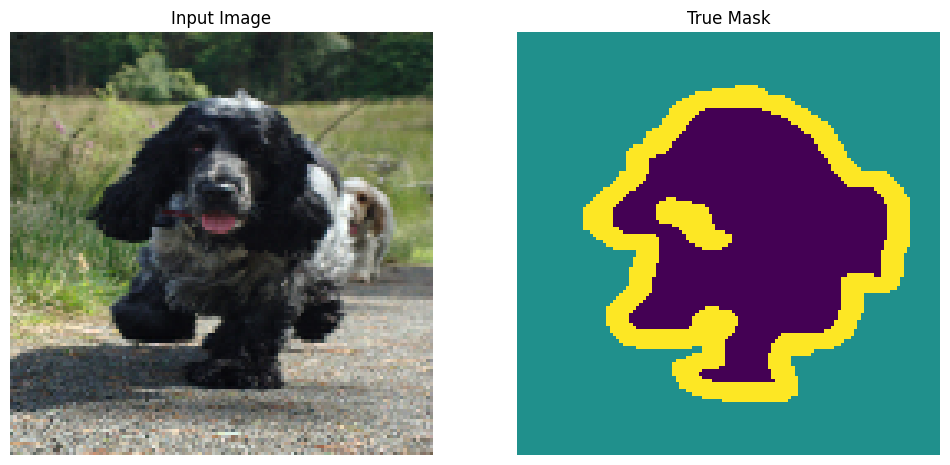

In [ ]:
# Diplay image and mask
img_num = np.random.randint(0,len(X_val))
print(f'Image number: {img_num}')
# Assign an image from validation set to sample_image
sample_image, sample_mask = X_val_p1[img_num],Y_val[img_num]
# For sample_image dislay original image, ie X_val[img_num], for sample_image created here 
# is pre-processed for pre-trained model 
display([X_val[img_num],sample_mask])

In [ ]:
model_1 = create_model(BACKBONE_1,optim_2,total_loss)
current_model = model_1



9406464/9406464 [==============================] - 0s 0us/step


1/1 [==============================] - 10s 10s/step


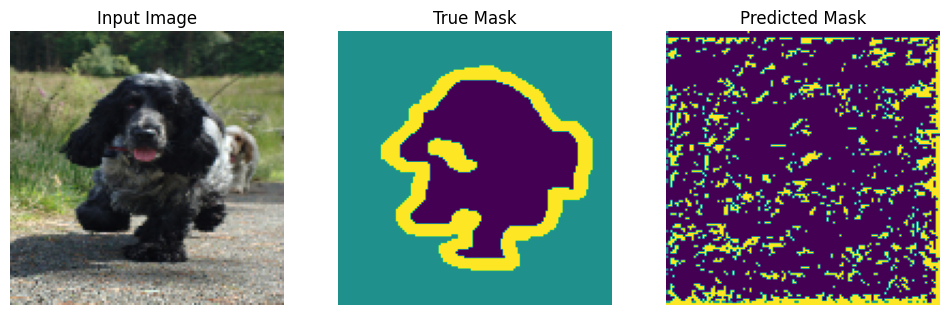

In [ ]:

show_predictions()

In [ ]:
# Check how many layers the model has
len(model_1.layers)

196

1/1 [==============================] - 0s 24ms/step


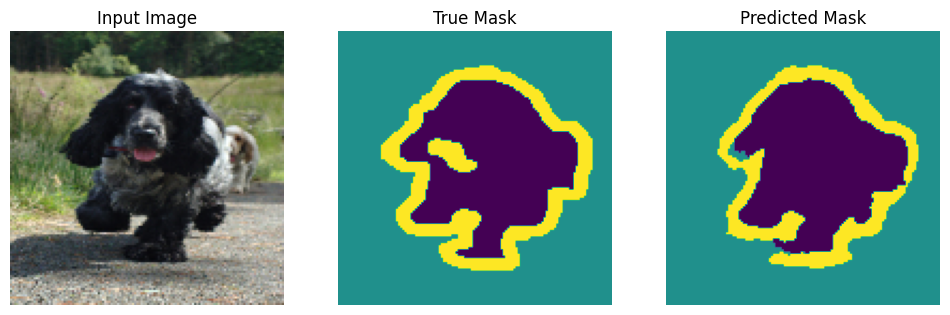


Sample Prediction after epoch 61


Epoch 62: val_loss did not improve from 0.31375
262/262 [==============================] - 24s 93ms/step - loss: 0.3100 - mean_io_u: 0.7326 - val_loss: 0.3138 - val_mean_io_u: 0.7303 - lr: 2.7830e-05
Epoch 62: early stopping


In [ ]:
# Pre-train model
history_1 = current_model.fit(X_train_p1, 
            Y_train_cat,
            batch_size=25, 
            epochs=75,
            verbose=1,
            validation_data=(X_val_p1,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u', 'lr'])


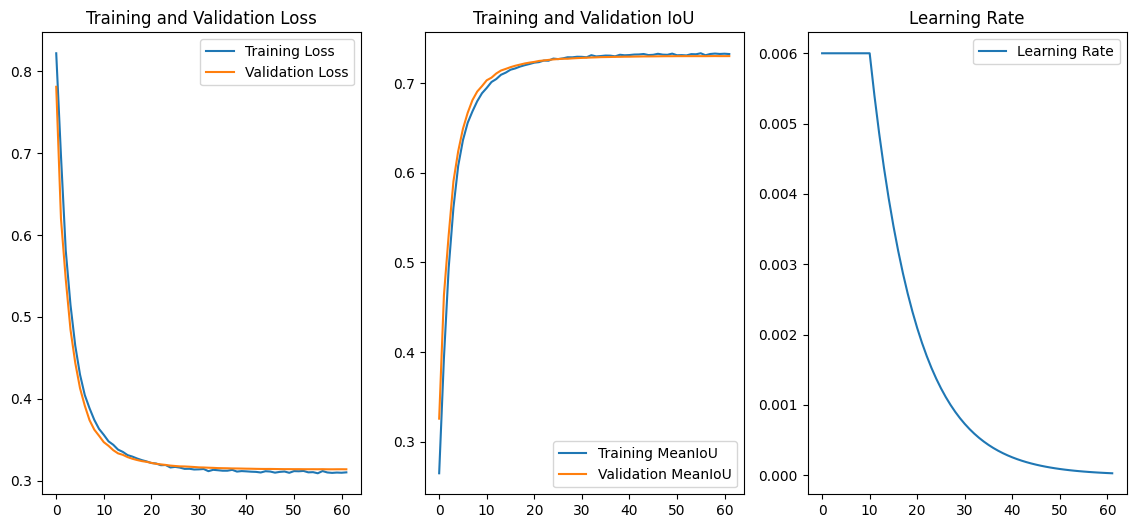

Training loss: 0.310	Training meanIoU: 0.733
Validation loss: 0.314	Validation meanIoU: 0.730


In [ ]:
show_history(history_1)

In [ ]:
model_1.evaluate(X_test_p1,Y_test_cat)

3/3 [==============================] - 2s 446ms/step - loss: 0.3089 - mean_io_u: 0.7349


[0.30888867378234863, 0.7349444031715393]

In [ ]:
#current_model.save_weights('/gdrive/MyDrive/saved_models/oxford_pet_img-segment/test_model.ckpt')

In [ ]:
#current_model.load_weights('/gdrive/MyDrive/saved_models/oxford_pet_img-segment/test_model.ckpt')

In [ ]:
#===============================================================================================
img_v100,mask_v100 = X_val_p1[100],Y_val[100]
img_v100_input = np.expand_dims(img_v100,0)
pred_v100 = current_model.predict(img_v100_input)

1/1 [==============================] - 0s 72ms/step


In [ ]:
print(f'pred_v100 shape: {pred_v100.shape}')
pred_v100[0][127][127] # [index for image][row][column]
#==========================================================================

pred_v100 shape: (1, 128, 128, 3)


array([0.15753302, 0.35348153, 0.48898542], dtype=float32)

In [ ]:
#======================= Model 2 ==============================================================

In [29]:
BACKBONE_2 = 'efficientnetb7'
preprocess_input_2 = sm.get_preprocessing(BACKBONE_2)

# preprocess input
X_train_p2 = preprocess_input_2(X_train.copy())
X_val_p2 = preprocess_input_2(X_val.copy())
X_test_p2 = preprocess_input_2(X_test.copy())

In [ ]:
model_2 = create_model(BACKBONE_2,optim_2,total_loss)
current_model = model_2

258434480/258434480 [==============================] - 2s 0us/step


Image number: 89


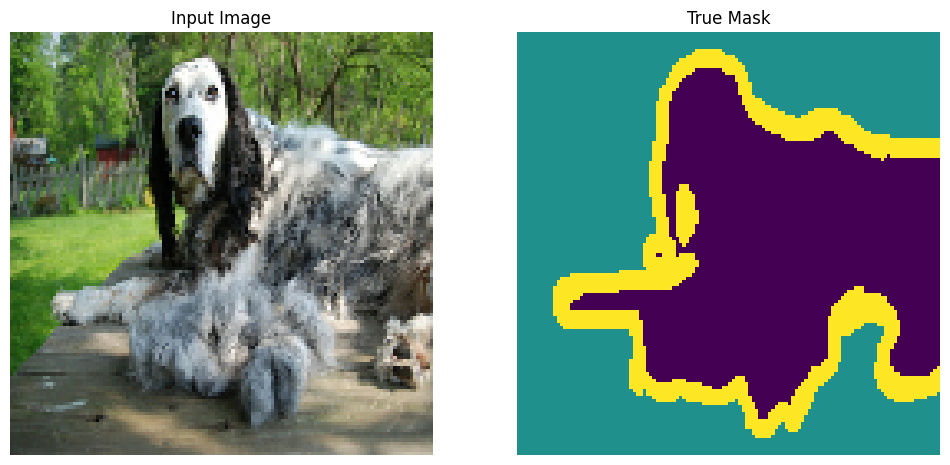

In [36]:
# Diplay image and mask
img_num = np.random.randint(0,len(X_val))
print(f'Image number: {img_num}')
# Assign an image from validation set to sample_image
sample_image, sample_mask = X_val_p2[img_num],Y_val[img_num]
# For sample_image dislay original image, ie X_val[img_num], for sample_image created here 
# is pre-processed for pre-trained model 
display([X_val[img_num],sample_mask])

In [ ]:
len(model_2.layers)

847

In [ ]:
callback_list

In [30]:
checkpoint_path_2 = "/gdrive/MyDrive/saved_models/oxford_pet_img-segment/model_2(efficientnet7).ckpt"

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

callback_list.append(checkpoint)

In [31]:
callback_list

In [ ]:
# This function keeps reduces learning based on epoch number.
def scheduler(epoch, lr):
  if epoch <= 1:
    return lr
  else:
    return lr * 0.5 

lr_schedule_2 = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
callback_list.append(lr_schedule_2)

In [ ]:
callback_list

1/1 [==============================] - 12s 12s/step


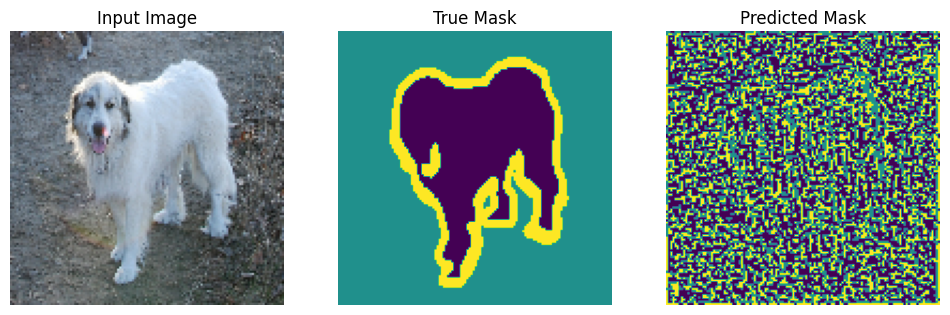

In [ ]:
show_predictions()

1/1 [==============================] - 0s 42ms/step


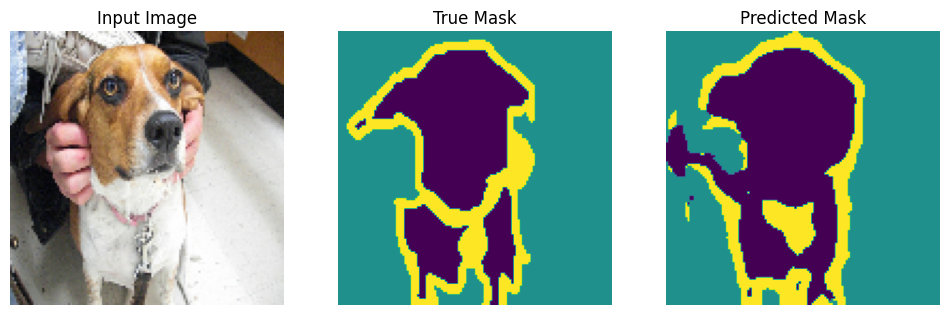


Sample Prediction after epoch 14


Epoch 15: val_loss did not improve from 0.25442
262/262 [==============================] - 119s 454ms/step - loss: 0.2530 - mean_io_u: 0.7834 - val_loss: 0.2546 - val_mean_io_u: 0.7822 - lr: 1.2207e-08
Epoch 15: early stopping


In [ ]:
# Pre-train model
history_2 = model_2.fit(X_train_p2, 
            Y_train_cat,
            batch_size=25, 
            epochs=30,
            verbose=1,
            validation_data=(X_val_p2,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u', 'lr'])


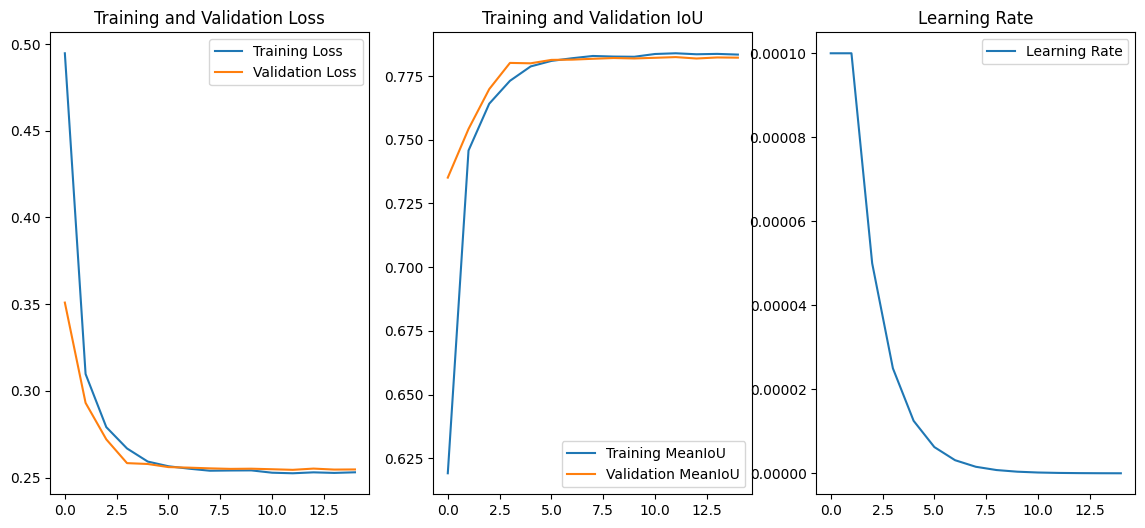

Training loss: 0.253	Training meanIoU: 0.783
Validation loss: 0.255	Validation meanIoU: 0.782


In [ ]:
show_history(history_2)

In [ ]:
!ls /gdrive/MyDrive/saved_models/oxford_pet_img-segment/

 checkpoint
 model_1.ckpt.data-00000-of-00001
 model_1.ckpt.index
'model_2(efficientnet7).ckpt.data-00000-of-00001'
'model_2(efficientnet7).ckpt.index'
'model_2(efficientnet7)_ft.ckpt.data-00000-of-00001'
'model_2(efficientnet7)_ft.ckpt.index'
 test_model.ckpt.data-00000-of-00001
 test_model.ckpt.index


In [ ]:
model_2.evaluate(X_test_p2,Y_test_cat,verbose=1)

3/3 [==============================] - 0s 106ms/step - loss: 0.2344 - mean_io_u: 0.8009


[0.23442018032073975, 0.8008607029914856]

In [32]:
# Create another model_2
saved_model_2 = create_model(BACKBONE_2,optim_3,total_loss)
current_model = saved_model_2



258434480/258434480 [==============================] - 7s 0us/step


In [33]:
# Check learning rate for optimizer
saved_model_2.optimizer.learning_rate

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=3e-05>

In [34]:
# Load saved weights
saved_model_2.load_weights(checkpoint_path_2)

In [35]:
# Evaluate saved model
saved_model_2.evaluate(X_test_p2,Y_test_cat,verbose=1)

3/3 [==============================] - 16s 772ms/step - loss: 0.2345 - mean_io_u: 0.8008


[0.23447266221046448, 0.8008473515510559]

In [37]:
# Make encoder layers trainable for fine tuning
saved_model_2.trainable = True


In [42]:
#saved_model_2.summary()
LR_3

3e-05

In [43]:
# ref link: https://stackoverflow.com/questions/59737875/keras-change-learning-rate
# Change learning rate to LR_3 (3e-05)
from keras import backend as K
K.set_value(saved_model_2.optimizer.learning_rate, LR_3)
print("Learning rate before second fit:", saved_model_2.optimizer.learning_rate.numpy())

Learning rate before second fit: 3e-05


In [44]:
# Save fine tuned model
checkpoint_path_2b = "/gdrive/MyDrive/saved_models/oxford_pet_img-segment/model_2(efficientnet7)_ft.ckpt"

In [45]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_2b,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

callback_list.append(checkpoint)

In [46]:
#for i in range (3):
#  callback_list.pop()
callback_list

In [47]:
# This function keeps reduces learning based on epoch number.
def scheduler_2b(epoch, lr):
    return lr


lr_schedule_2b = tf.keras.callbacks.LearningRateScheduler(scheduler_2b)

In [48]:
callback_list.append(lr_schedule_2b)
callback_list

1/1 [==============================] - 0s 43ms/step


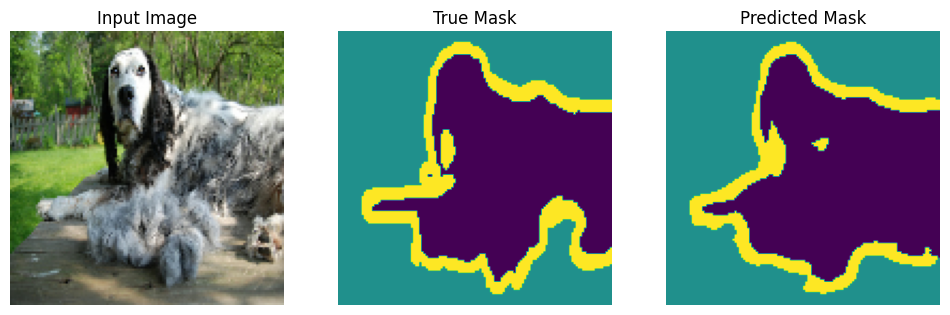


Sample Prediction after epoch 17


Epoch 18: val_loss did not improve from 0.24093
262/262 [==============================] - 119s 453ms/step - loss: 0.2033 - mean_io_u: 0.8226 - val_loss: 0.2411 - val_mean_io_u: 0.7913 - lr: 3.0000e-05
Epoch 18: early stopping


In [49]:
# Pre-train model
history_2b = saved_model_2.fit(X_train_p2, 
            Y_train_cat,
            batch_size=25, 
            epochs=30,
            verbose=1,
            validation_data=(X_val_p2,Y_val_cat),
            callbacks=callback_list)

dict_keys(['loss', 'mean_io_u', 'val_loss', 'val_mean_io_u', 'lr'])


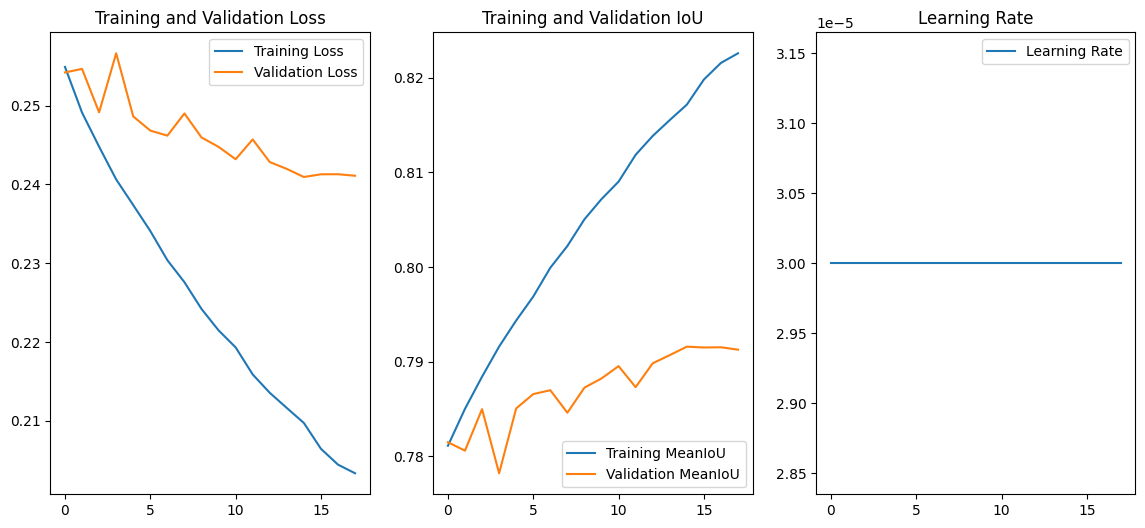

Training loss: 0.203	Training meanIoU: 0.823
Validation loss: 0.241	Validation meanIoU: 0.791


In [50]:
show_history(history_2b)

In [51]:
saved_model_2.evaluate(X_test_p2,Y_test_cat,verbose=1)

3/3 [==============================] - 0s 109ms/step - loss: 0.2151 - mean_io_u: 0.8131


[0.2151181399822235, 0.8130838871002197]